In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
PATH_DATA = "./datasets/titanic"

# Download the dataset

In [3]:
!kaggle competitions download -c titanic -p {PATH_DATA}

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip -n {PATH_DATA}/titanic.zip -d {PATH_DATA}

Archive:  ./datasets/titanic/titanic.zip


# EDA

## Quick look

In [5]:
df_raw = pd.read_csv(f'{PATH_DATA}/train.csv')

In [6]:
df_raw.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
df_raw.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891,NaN,NaN,NaN,446,257.354,1,223.5,446,668.5,891
Survived,891,NaN,NaN,NaN,0.383838,0.486592,0,0,0,1,1
Pclass,891,NaN,NaN,NaN,2.30864,0.836071,1,2,3,3,3
Name,891,891,"Carlsson, Mr. Frans Olof",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714,NaN,NaN,NaN,29.6991,14.5265,0.42,20.125,28,38,80
SibSp,891,NaN,NaN,NaN,0.523008,1.10274,0,0,0,1,8
Parch,891,NaN,NaN,NaN,0.381594,0.806057,0,0,0,0,6
Ticket,891,681,CA. 2343,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891,NaN,NaN,NaN,32.2042,49.6934,0,7.9104,14.4542,31,512.329


> * Name: all unique values
* Age: some missing data
* Ticket: almost unique (681/891, freq=7)
* Cabin: High ratio of missing data; almost unique (147/204, freq=4)
* Embarked: 2 missing values

## Handling missing / dirty data

### Drop unique features

In [8]:
# PassengerId and Name are unique. Drop them before our EDA
cols = ['PassengerId', 'Name']
# Ticket (ticket number) and Cabin (cabin number) are almost unique. Drop them too
cols += (['Ticket', 'Cabin'])

# Make a copy so we won't accidentally modify the raw dataset
df = df_raw.drop(cols, axis=1).copy()

In [9]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Missing embarked

In [10]:
# Who are those with missing embarked daata
df[df['Embarked'].isna()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,female,38.0,0,0,80.0,NaN
829,1,1,female,62.0,0,0,80.0,NaN


In [11]:
# Who else is paying $80 fare
df[df['Fare'] == 80]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,female,38.0,0,0,80.0,NaN
829,1,1,female,62.0,0,0,80.0,NaN


> These two come abroad alone (both SibSp & Parch = 0), and they are the only one paying $80. As there is no way to find out the value, mark Embarked as unknown

In [12]:
df['Embarked'].fillna('unknown', inplace=True)

### Missing age

In [13]:
# Those with missing age
df[df['Age'].isna()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
5,0,3,male,NaN,0,0,8.4583,Q
17,1,2,male,NaN,0,0,13.0000,S
19,1,3,female,NaN,0,0,7.2250,C
26,0,3,male,NaN,0,0,7.2250,C
28,1,3,female,NaN,0,0,7.8792,Q
...,...,...,...,...,...,...,...,...
859,0,3,male,NaN,0,0,7.2292,C
863,0,3,female,NaN,8,2,69.5500,S
868,0,3,male,NaN,0,0,9.5000,S
878,0,3,male,NaN,0,0,7.8958,S


In [14]:
# Look at the correlation of Age
df.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


> Doesn't look like we can impute the age with regression. Mean substitution may be a good way. We will revisit this later on.

## Numerical variables

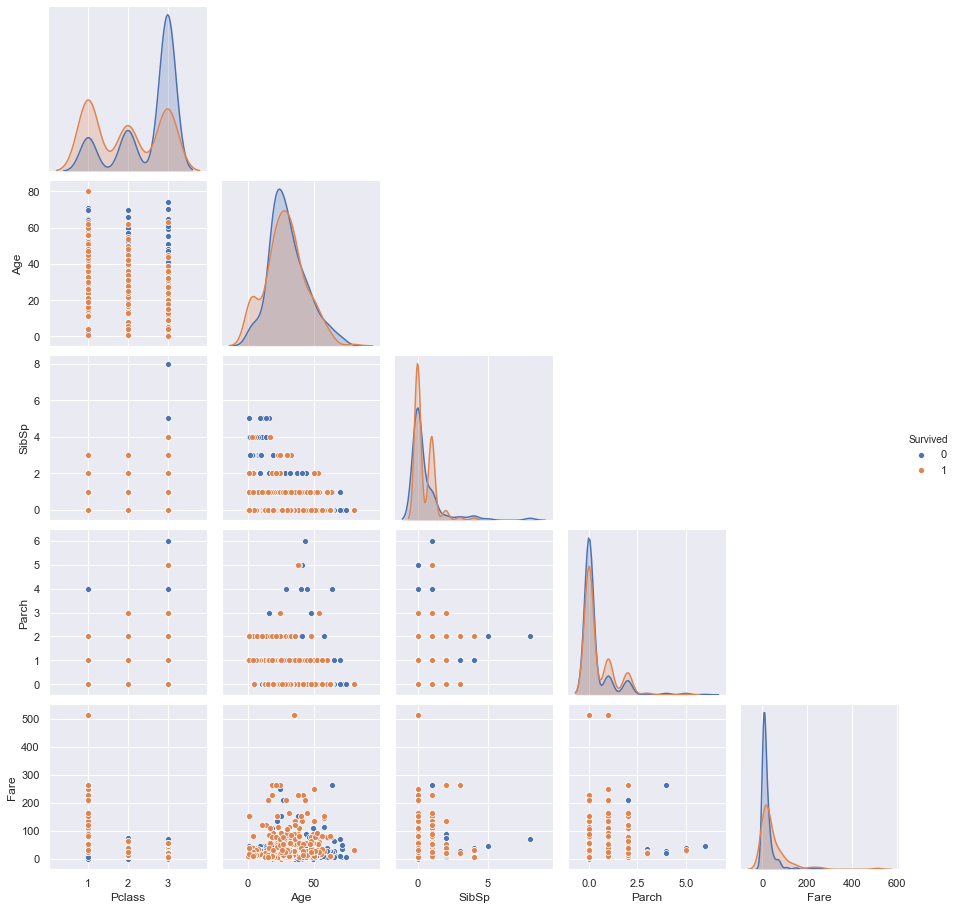

In [15]:
sns.pairplot(df, hue='Survived', corner=True);

> If we consider the features separately, we can see that there are much more survivors in Ticket Class 1 (`Pclass`) and children (`Age`).

## Categorical variables

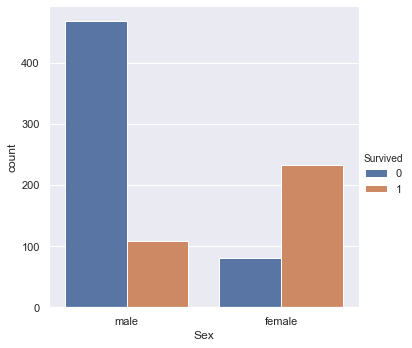

In [16]:
sns.catplot(x='Sex', kind='count', hue='Survived', data=df)

> Female has a higher chance to survive than male

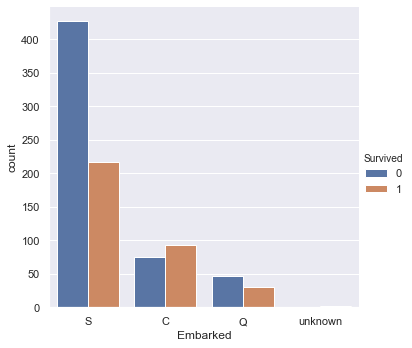

In [17]:
sns.catplot(x='Embarked', kind='count', hue='Survived', data=df)

> Passengers aboard from Southampton has the lowest survival rate

## Multi-dimension

### Age & Sex

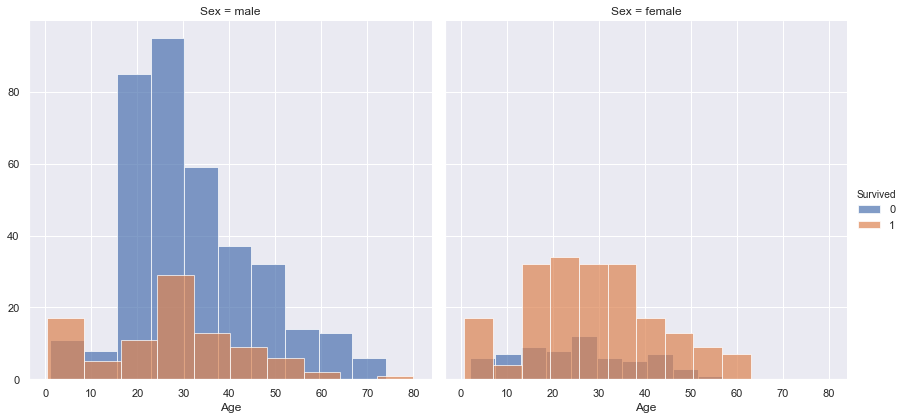

In [18]:
g = sns.FacetGrid(df, col="Sex", hue='Survived', height=6)
g.map(plt.hist, 'Age', alpha=.7)
g.add_legend()

### Sex & Pclass

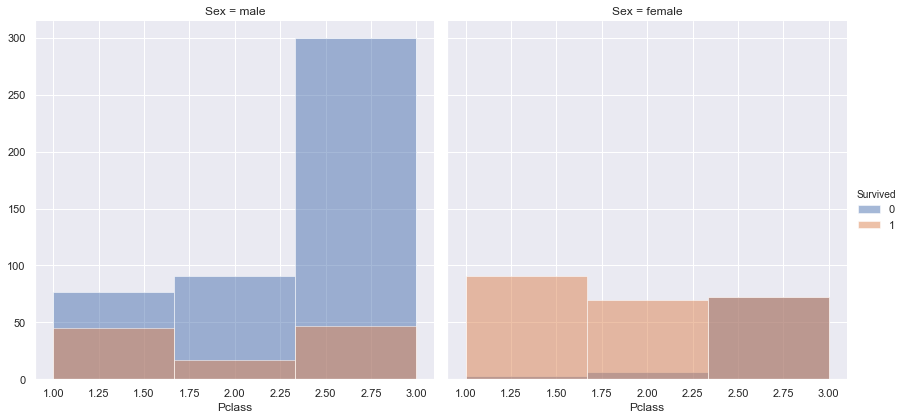

In [19]:
g = sns.FacetGrid(df, col="Sex", hue='Survived', height=6)
g.map(plt.hist, 'Pclass', alpha=.5, bins=3)
g.add_legend()

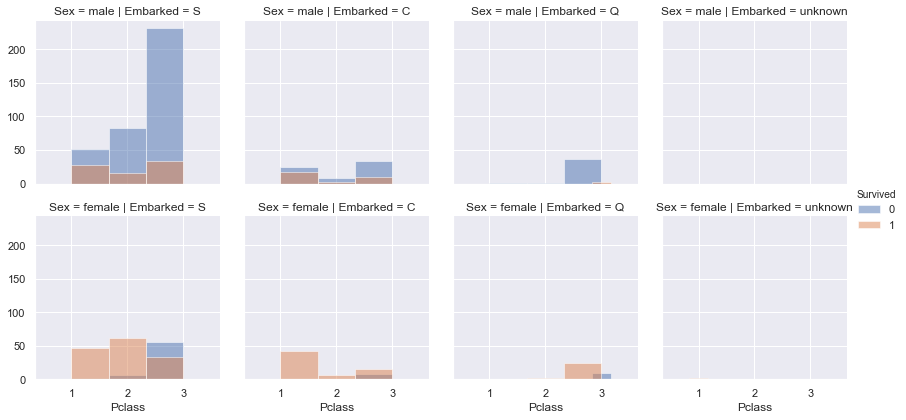

In [20]:
g = sns.FacetGrid(df, col="Embarked", row='Sex', hue='Survived', height=3)
g.map(plt.hist, 'Pclass', alpha=.5, bins=3)
g.add_legend()